In [1]:
import numpy as np
import matplotlib.pyplot as plt
import visualization
import os
from gta_math import points_to_homo, ndc_to_view, construct_proj_matrix, view_to_world, construct_view_matrix, ndcs_to_pixels
from visualization import load_depth, save_pointcloud_csv
import progressbar
from pointcloud_to_voxelmap import pointclouds_to_voxelmap
from joblib import Parallel, delayed
from configparser import ConfigParser
from PIL import Image
import pickle
from voxelmaps import camera_to_pointcloud, load_scene_db_data, get_main_image_name, scene_to_pointcloud, scene_to_voxelmap, NoMainImageException, scene_to_voxelmap_with_map, get_main_image, pointclouds_to_voxelmap_with_map
import voxelmaps
import time
import csv
import random
import pcl

In [2]:
ini_file = "gta-postprocessing.ini"
visualization.multi_page = False
visualization.ini_file = ini_file

conn = visualization.get_connection()
cur = conn.cursor()

CONFIG = ConfigParser()
CONFIG.read(ini_file)
in_directory = CONFIG["Images"]["Tiff"]
out_directory = r'D:\showing-pointclouds\subsampling'


In [3]:
run_id = 6

cur.execute("""SELECT DISTINCT scene_id \
  FROM snapshots \
  WHERE run_id = {} \
  """.format(run_id))

scenes = []
for row in cur:
    res = dict(row)
    scenes.append(res)

image_names = {}

print('There are {} scenes'.format(len(scenes)))
voxelmaps.MAX_DISTANCE = 50 # in meters, meaning I care only for point up to 20 meters


There are 8438 scenes


In [4]:
scene_id = scenes[100]['scene_id']
scene_id

'c2b14a9e-9476-4eb3-89ce-e24cc36c6bd8'

In [5]:
cameras = load_scene_db_data(scene_id)

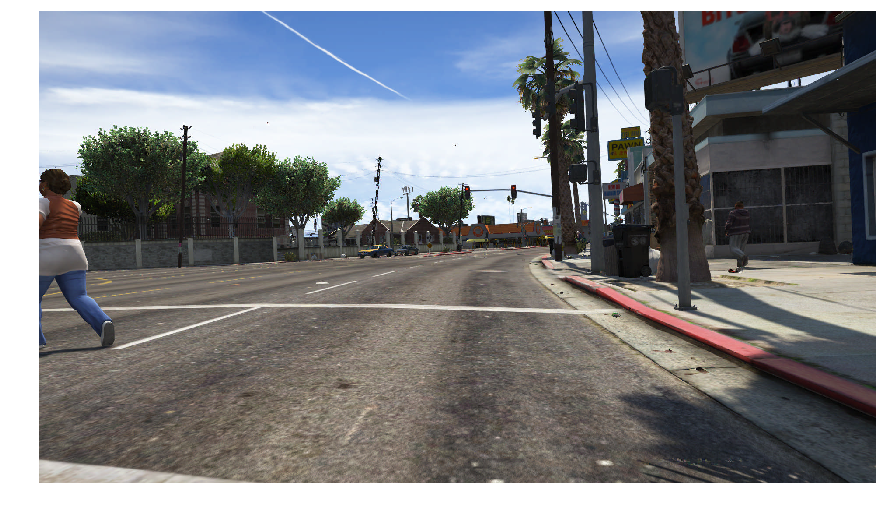

In [6]:
main_img = get_main_image_name(cameras)
infile = os.path.join(in_directory, main_img+'.tiff')
im = Image.open(infile)
im = im.convert(mode="RGB")

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(im)
plt.show()

In [49]:
pointclouds, cam_positions = scene_to_pointcloud(cameras)
pointcloud = np.hstack(pointclouds)
ps = [pcl.PointCloud(pc.astype(dtype=np.float32).T) for pc in pointclouds]
pcl_voxelmaps = [p.make_voxel_grid_filter() for p in ps]
save_pointcloud_csv(pointcloud.T[:, 0:3], '{}/orig-pointcloud-{}.csv'.format(out_directory, scene_id))

In [51]:
pcl_size = sum([p.shape[1] for p in pointclouds])
pcl_size

5691726

In [52]:
pointcloud.shape

(3, 5691726)

In [62]:
start = time.time()
voxels, values, voxel_size, map_obj = pointclouds_to_voxelmap_with_map(pointclouds, cam_positions)
voxels = voxels[:, values > 0]
end = time.time()
print('time to create voxelmap: {}'.format(end - start))
save_pointcloud_csv(voxels.T[:, 0:3], '{}/orig-voxelmap-{}.csv'.format(out_directory, scene_id))

time to create voxelmap: 13.393088102340698


In [66]:
start = time.time()
for pcl_voxelmap in pcl_voxelmaps:
    pcl_voxelmap.set_leaf_size(x=5e-2, y=5e-2, z=5e-2)
filtered_ps = [pcl_voxelmap.filter() for pcl_voxelmap in pcl_voxelmaps]
filtered_pointclouds = [filtered_p.to_array().T for filtered_p in filtered_ps]
filtered_pointcloud = np.hstack(filtered_pointclouds)
print(filtered_pointcloud.shape)
voxels, values, voxel_size, map_obj = pointclouds_to_voxelmap_with_map(filtered_pointclouds, cam_positions)
voxels = voxels[:, values > 0]
end = time.time()
print('time to create voxelmap: {}'.format(end - start))
save_pointcloud_csv(voxels.T[:, 0:3], '{}/5e-2-voxelmap-{}.csv'.format(out_directory, scene_id))

(3, 755262)
time to create voxelmap: 5.038030624389648


In [65]:
save_pointcloud_csv(filtered_pointcloud.T[:, 0:3], '{}/5e-2-pointcloud-{}.csv'.format(out_directory, scene_id))

In [67]:
start = time.time()
for pcl_voxelmap in pcl_voxelmaps:
    pcl_voxelmap.set_leaf_size(x=1e-1, y=1e-1, z=1e-1)
filtered_ps = [pcl_voxelmap.filter() for pcl_voxelmap in pcl_voxelmaps]
filtered_pointclouds = [filtered_p.to_array().T for filtered_p in filtered_ps]
filtered_pointcloud = np.hstack(filtered_pointclouds)
print(filtered_pointcloud.shape)
voxels, values, voxel_size, map_obj = pointclouds_to_voxelmap_with_map(filtered_pointclouds, cam_positions)
voxels = voxels[:, values > 0]
end = time.time()
print('time to create voxelmap: {}'.format(end - start))
save_pointcloud_csv(voxels.T[:, 0:3], '{}/1e-1-voxelmap-{}.csv'.format(out_directory, scene_id))

(3, 288843)
time to create voxelmap: 2.5840251445770264


In [60]:
save_pointcloud_csv(filtered_pointcloud.T[:, 0:3], '{}/1e-1-pointcloud-{}.csv'.format(out_directory, scene_id))